### Deep learning with Word2Vec Models
We will combine the 1D Convolutional model with Word2Vec embeddings.


In [1]:
!pip install --upgrade numpy
!pip install --upgrade pandas
#!pip install pyspark==2.4.5
!pip install -U scikit-learn
!pip install gensim

     |████████████████████████████████| 14.5MB 7.7MB/s eta 0:00:01
ERROR: tensorflow 1.13.1 requires tensorboard<1.14.0,>=1.13.0, which is not installed.
ERROR: autoai-libs 1.10.5 has requirement pandas>=0.24.2, but you'll have pandas 0.24.1 which is incompatible.
  Found existing installation: numpy 1.15.4
    Uninstalling numpy-1.15.4:
      Successfully uninstalled numpy-1.15.4
     |████████████████████████████████| 10.5MB 8.1MB/s eta 0:00:01
ERROR: ibm-watson-machine-learning 1.0.10 has requirement pandas<=0.25.3, but you'll have pandas 1.1.2 which is incompatible.
  Found existing installation: pandas 0.24.1
    Uninstalling pandas-0.24.1:
      Successfully uninstalled pandas-0.24.1
     |████████████████████████████████| 6.8MB 7.6MB/s eta 0:00:01
     |████████████████████████████████| 307kB 30.4MB/s eta 0:00:01
ERROR: autoai-libs 1.10.5 has requirement scikit-learn==0.20.3, but you'll have scikit-learn 0.23.2 which is incompatible.
  Found existing installation: scikit-learn 0

In [2]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from pprint import pprint
from time import time
import logging
import numpy as np
import pandas as pd
import string
import re
from datetime import datetime
from packaging import version

from ibm_botocore.client import Config
import ibm_boto3

from sklearn.model_selection import train_test_split
#pd.show_versions()

In [3]:
#Get our data from IBM Cloud

# @hidden_cell
# The following code contains the credentials for a file in your IBM Cloud Object Storage.
# You might want to remove those credentials before you share your notebook.
credentials_news = {
    'IAM_SERVICE_ID': 'iam-ServiceId-32e8ee67-397c-4ff1-b69b-543172331f43',
    'IBM_API_KEY_ID': 'Rx4FR4JSAueCnnIsoevsgYgOsuh8LCXtbkFpFpC0EmVU',
    #'ENDPOINT': 'https://s3-api.us-geo.objectstorage.service.networklayer.com',
    'ENDPOINT':'https://s3-api.us-geo.objectstorage.softlayer.net',
    'IBM_AUTH_ENDPOINT': 'https://iam.cloud.ibm.com/oidc/token',
    'BUCKET': 'advanceddatasciencecapstone-donotdelete-pr-tqabpnbxebk8rm',
    'FILE': 'dfTrueFalseNews.pkl'
}

def download_file_cos(credentials,local_file_name,key):  
    cos = ibm_boto3.client(service_name='s3',
    ibm_api_key_id=credentials['IBM_API_KEY_ID'],
    ibm_service_instance_id=credentials['IAM_SERVICE_ID'],
    ibm_auth_endpoint=credentials['IBM_AUTH_ENDPOINT'],
    config=Config(signature_version='oauth'),
    endpoint_url=credentials['ENDPOINT'])
    try:
        res=cos.download_file(Bucket=credentials['BUCKET'],Key=key,Filename=local_file_name)
    except Exception as e:
        print(Exception, e)
    else:
        print('File Downloaded')

def upload_file_cos(credentials,local_file_name,key):  
    cos = ibm_boto3.client(service_name='s3',
    ibm_api_key_id=credentials['IBM_API_KEY_ID'],
    ibm_service_instance_id=credentials['IAM_SERVICE_ID'],
    ibm_auth_endpoint=credentials['IBM_AUTH_ENDPOINT'],
    config=Config(signature_version='oauth'),
    endpoint_url=credentials['ENDPOINT'])
    try:
        res=cos.upload_file(Filename=local_file_name, Bucket=credentials['BUCKET'],Key=key)
    except Exception as e:
        print(Exception, e)
    else:
        print(' File Uploaded')
        
dfNews = download_file_cos(credentials_news, "dfTrueFalseNews.pkl", "dfTrueFalseNews.pkl")
dfTrueFalseNews_tokenized  = download_file_cos(credentials_news,'dfTrueFalseNews_tokenized.pkl','dfTrueFalseNews_tokenized.pkl')

File Downloaded
File Downloaded


In [4]:
dfNewsTemp = pd.read_pickle('dfTrueFalseNews.pkl')
dfTrueFalseNews_tokenized = pd.read_pickle('dfTrueFalseNews_tokenized.pkl')
#dfNews['truthvalue'] = pd.Categorical(dfNews['truthvalue'])

x = dfNewsTemp['text'].values

y = dfNewsTemp['truthvalue'].values

print (dfNewsTemp.shape, dfNewsTemp.columns, '\n', dfNewsTemp.dtypes, type(x), type(y))


(1126, 3) Index(['text', 'source', 'truthvalue'], dtype='object') 
 text          object
source        object
truthvalue    object
dtype: object <class 'numpy.ndarray'> <class 'numpy.ndarray'>


### Prepare the Text for Word2Vec
1. Change all the text to lower case
2. Split stories into sentences.
3. Word Tokenization and removing non-alpha text.

In [5]:
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import *
from nltk.corpus import wordnet as wn
from collections import defaultdict
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

# reproduce the same result every time the script is run.
np.random.seed(500)

[nltk_data] Downloading package punkt to /home/dsxuser/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /home/dsxuser/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/dsxuser/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/dsxuser/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [6]:
from gensim.models import Word2Vec
download_file_cos(credentials_news,"embedding_word2vec.model","embedding_word2vec.model")
model = Word2Vec.load("embedding_word2vec.model")
model_vectors = model.wv
words = list(model.wv.vocab)
print('Vocabulary size: %d' % len(words))

File Downloaded
Vocabulary size: 21671


In [8]:
# Split into Train_X, Train_Y, Test_X, Test_Y
from sklearn import model_selection
Train_X, Test_X, Train_Y, Test_Y = model_selection.train_test_split(dfNewsTemp['text'],dfNewsTemp['truthvalue'],test_size=0.1)

In [22]:
type(Test_Y)

pandas.core.series.Series

### Define a Vocabulary based on all the words in our stories
Save it as vocab.txt
based on https://machinelearningmastery.com/develop-word-embedding-model-predicting-movie-review-sentiment/

In [8]:
from string import punctuation
from os import listdir
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
wnl = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))


# from: https://www.machinelearningplus.com/nlp/lemmatization-examples-python/
# Lemmatize with POS Tag
from nltk.corpus import wordnet

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)


# turn a doc into clean tokens
def clean_doc(doc):
    # split into tokens by white space
    doc = doc.lower()
    tokens = doc.split()
    # remove punctuation from each token
    table = str.maketrans('', '', punctuation)
    tokens = [w.translate(table) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # filter out stop words
    #stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]
    tokens = [wnl.lemmatize(w, get_wordnet_pos(w)) for w in tokens]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 1]
    return tokens

# load doc and add to vocab
def add_doc_to_vocab(story, vocab):
    # load doc
    #doc = load_doc(filename)
    # clean doc
    tokens = clean_doc(story)
    # update counts
    vocab.update(tokens)

# load all docs in a directory
def process_docs(x, vocab):
    # walk through all files in the folder
    for story in x:
        # skip any reviews in the test set
        # add doc to vocab
        add_doc_to_vocab(story, vocab)

# define vocab
vocab = Counter()
# add all docs to vocab
process_docs(Train_X, vocab)
#process_docs('txt_sentoken/pos', vocab, True)
# print the size of the vocab
print(len(vocab))
# print the top words in the vocab
print(vocab.most_common(50))




17697
[('say', 2013), ('get', 879), ('one', 873), ('make', 867), ('go', 856), ('new', 821), ('like', 792), ('time', 780), ('year', 756), ('would', 691), ('take', 634), ('also', 604), ('know', 581), ('show', 572), ('people', 565), ('come', 552), ('want', 517), ('first', 517), ('trump', 516), ('see', 478), ('told', 476), ('source', 476), ('star', 471), ('work', 464), ('think', 450), ('report', 450), ('back', 448), ('well', 439), ('two', 439), ('thing', 430), ('even', 425), ('life', 416), ('look', 399), ('could', 391), ('last', 380), ('give', 366), ('way', 357), ('day', 354), ('world', 348), ('love', 347), ('family', 345), ('friend', 343), ('use', 341), ('president', 335), ('accord', 327), ('state', 322), ('really', 321), ('child', 316), ('many', 301), ('may', 298)]


In [14]:
#We can step through the vocabulary and remove all words that have a low occurrence, such as only being used once or twice
min_occurance = 2
tokens = [k for k,c in vocab.items() if c >= min_occurance]
print(len(tokens), tokens[1:10])

10312 ['claim', 'trump', 'touch', 'exclusive', 'interview', 'hollywood', 'inquirer', 'say', 'mr']


In [13]:
def save_list(lines, filename):
    # convert lines to a single blob of text
    data = '\n'.join(lines)
    # open file
    file = open(filename, 'w')
    # write text
    file.write(data)
    # close file
    file.close()
 
# save tokens to a vocabulary file
save_list(tokens, 'vocab.txt')
upload_file_cos(credentials_news,'vocab.txt','vocab.txt')

 File Uploaded


## Use simple pruned vocabulary from above in our deep learning model.

In [12]:
from string import punctuation
from os import listdir
from numpy import array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.data import Dataset

In [13]:
# based on https://machinelearningmastery.com/develop-word-embedding-model-predicting-movie-review-sentiment/


wnl = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

from nltk.corpus import wordnet

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

# load doc into memory
def load_doc(filename):
    # open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text

# turn a doc into clean tokens
def clean_doc(doc, vocab):
    # split into tokens by white space
    tokens = doc.split()
    # remove punctuation from each token
    table = str.maketrans('', '', punctuation)
    tokens = [w.translate(table) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    tokens = [wnl.lemmatize(w, get_wordnet_pos(w)) for w in tokens]
    # filter out tokens not in vocab
    tokens = [w for w in tokens if w in vocab]
    
    tokens = ' '.join(tokens)
    return tokens

# load all docs in a directory
def process_docs(x, vocab):
    documents = list()
    # walk through all files in the folder
    #for filename in listdir(directory):
    for doc in x:
        # skip any reviews in the test set
        #if is_trian and filename.startswith('cv9'):
        #    continue
        #if not is_train: # and not filename.startswith('cv9'):
        #    continue
        # create the full path of the file to open
        #path = directory + '/' + filename
        # load the doc
        #doc = load_doc(path)
        # clean doc
        tokens = clean_doc(doc, vocab)
        # add to list
        documents.append(tokens)
    return documents

# load the vocabulary
download_file_cos(credentials_news,'vocab.txt','vocab.txt')
vocab_filename = 'vocab.txt'
vocab = load_doc(vocab_filename)
vocab = vocab.split()
vocab = set(vocab)

# load all training reviews
#positive_docs = process_docs(Train_X, vocab)
#negative_docs = process_docs('txt_sentoken/neg', vocab, True)
train_docs = process_docs(Train_X, vocab)

# create the tokenizer
tokenizer = Tokenizer()
# fit the tokenizer on the documents
tokenizer.fit_on_texts(train_docs)

# sequence encode
encoded_docs = tokenizer.texts_to_sequences(train_docs)
# pad sequences
max_length = max([len(s.split()) for s in train_docs])
Xtrain = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
# define training labels
ytrain = Train_Y #array([0 for _ in range(900)] + [1 for _ in range(900)])

# load all test reviews
#positive_docs = process_docs('txt_sentoken/pos', vocab, False)
#negative_docs = process_docs('txt_sentoken/neg', vocab, False)

test_docs = process_docs(Test_X, vocab)#  negative_docs + positive_docs
# sequence encode
encoded_docs = tokenizer.texts_to_sequences(test_docs)
# pad sequences
Xtest = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
# define test labels
ytest = Test_Y # array([0 for _ in range(100)] + [1 for _ in range(100)])

# define vocabulary size (largest integer value)
vocab_size = len(tokenizer.word_index) + 1

# zip test data

#validation_data = Dataset.zip((Xtest, ytest))

# define model
model = Sequential()
model.add(Embedding(vocab_size, 100, input_length=max_length))
model.add(Conv1D(filters=32, kernel_size=8, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
print(model.summary())

# compile network
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit network
history = model.fit(Xtrain, ytrain, epochs=9, validation_data=(Xtest, ytest))
# evaluate
loss, acc = model.evaluate(Xtest, ytest, verbose=0)
print('Test Accuracy: %f Loss: %f' % (acc*100, loss * 100 ))

import pickle


filename = "deeplearningWithOurVocab.history"
with open(filename, 'wb') as f:
    pickle.dump(history_dict, f)

File Downloaded
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 6347, 100)         752000    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 6340, 32)          25632     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 3170, 32)          0         
_________________________________________________________________
dense_1 (Dense)              (None, 3170, 256)         8448      
_________________________________________________________________
dropout (Dropout)            (None, 3170, 256)         0         
_________________________________________________________________
flatten (Flatten)            (None, 811520)            0         
___________

KeyboardInterrupt: 

In [26]:
history_dict
import pickle


filename = "deeplearningWithOurVocab.history"
with open(filename, 'wb') as f:
    pickle.dump(history_dict, f)
    
# with open(filename, 'rb') as f:
#     data = pickle.load(f)

{'loss': [0.6936446398290689,
  0.6590700409607732,
  0.5260552331466901,
  0.22124794996384925,
  0.043527796489406315,
  0.013775162661755191,
  0.0061495141015890965,
  0.00421735854026,
  0.0032471866025230852],
 'acc': [0.5202369,
  0.6189536,
  0.87956566,
  0.9851925,
  0.9970385,
  0.99802566,
  0.9990128,
  0.9990128,
  0.9990128],
 'val_loss': [0.6915967991921754,
  0.6837951240286363,
  0.6828052491213368,
  0.7544672737079384,
  0.8891760807121749,
  0.9134258300857206,
  0.8836142341647528,
  0.9235463363934407,
  0.9559872667346381],
 'val_acc': [0.45132744,
  0.54867256,
  0.54867256,
  0.539823,
  0.5132743,
  0.53097343,
  0.5663717,
  0.57522124,
  0.57522124]}

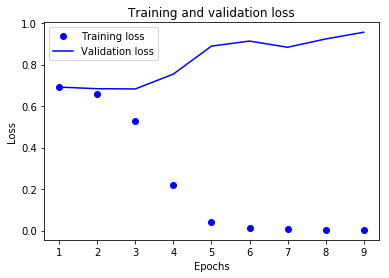

In [27]:
#model.save('deeplearning_newsvocab.model')
#upload_file_cos(credentials_news,'deeplearning_newsvocab.model', 'deeplearning_newsvocab.model')

#results = model2.evaluate(tfds_test)

#print(results)
history_dict = history.history
history_dict.keys()

acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


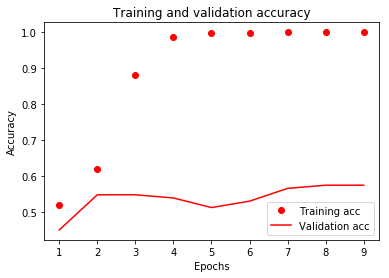

In [28]:
plt.clf()   # clear figure

plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### Use Word2Vec vectors as embedding layer for Deep Learning model

In [23]:
# save the word2vec embedding file in the format expected by next script

#raw_embedding = load_embedding(embeddingword2vec_fn)
#help(model.wv)
#model.wv.load(embeddingword2vec_fn)
model.wv.save_word2vec_format(embeddingword2vec_fn +"word2vec_format", binary=False)
embeddingword2vec_fn +"word2vec_format"
upload_file_cos(credentials_news, embeddingword2vec_fn +"word2vec_format", embeddingword2vec_fn +"word2vec_format")


 File Uploaded


In [56]:
# Split into Train_X, Train_Y, Test_X, Test_Y
from sklearn import model_selection
Train_X, Test_X, Train_Y, Test_Y = model_selection.train_test_split(dfNewsTemp['text'],dfNewsTemp['truthvalue'],test_size=0.1)
train_docs = tokenizer = test_docs = encoded_docs = None

In [58]:
len(Train_X), len(Test_X), len(Train_Y), len(Test_Y)

(1013, 113, 1013, 113)

In [60]:
# Use our word2vec vocabulary as input to the embedding layer.

from gensim.models import Word2Vec
from numpy import array
from numpy import asarray
from numpy import zeros

wnl = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

from nltk.corpus import wordnet

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

# load doc into memory
def load_doc(filename):
    # open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text

# turn a doc into clean tokens
def clean_doc(doc, vocab):
    # split into tokens by white space
    tokens = doc.split()
    # remove punctuation from each token
    table = str.maketrans('', '', punctuation)
    tokens = [w.translate(table) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    tokens = [wnl.lemmatize(w, get_wordnet_pos(w)) for w in tokens]
    # filter out tokens not in vocab
    tokens = [w for w in tokens if w in vocab]
    
    tokens = ' '.join(tokens)
    return tokens

# load all docs in a directory
def process_docs(x, vocab):
    documents = list()
    # walk through all files in the folder
    #for filename in listdir(directory):
    for doc in x:
        # skip any reviews in the test set
        #if is_trian and filename.startswith('cv9'):
        #    continue
        #if not is_train: # and not filename.startswith('cv9'):
        #    continue
        # create the full path of the file to open
        #path = directory + '/' + filename
        # load the doc
        #doc = load_doc(path)
        # clean doc
        tokens = clean_doc(doc, vocab)
        # add to list
        documents.append(tokens)
    return documents

# load embedding as a dict
def load_embedding(filename):
    # load embedding into memory, skip first line
    file = open(filename,'r')
    lines = file.readlines()[1:]
    file.close()
    # create a map of words to vectors
    embedding = dict()
    for line in lines:
        parts = line.split()
        # key is string word, value is numpy array for vector
        embedding[parts[0]] = asarray(parts[1:], dtype='float32')
    return embedding

# create a weight matrix for the Embedding layer from a loaded embedding
def get_weight_matrix(embedding, vocab):
    # total vocabulary size plus 0 for unknown words
    vocab_size = len(vocab) + 1
    # define weight matrix dimensions with all 0
    weight_matrix = zeros((vocab_size, 100))
    # step vocab, store vectors using the Tokenizer's integer mapping
    for word, i in vocab.items():
        weight_matrix[i] = embedding.get(word)
    return weight_matrix

# load the vocabulary
download_file_cos(credentials_news,'vocab.txt','vocab.txt')
vocab_filename = 'vocab.txt'
vocab = load_doc(vocab_filename)
vocab = vocab.split()
vocab = set(vocab)

# load all training reviews
#positive_docs = process_docs('txt_sentoken/pos', vocab, True)
#negative_docs = process_docs('txt_sentoken/neg', vocab, True)
#train_docs = negative_docs + positive_docs
if train_docs is None: 
    print ("processing training docs")
    train_docs = process_docs(Train_X, vocab)


# create the tokenizer
if tokenizer is None: 
    tokenizer = Tokenizer()
    # fit the tokenizer on the documents
    tokenizer.fit_on_texts(train_docs)

    # sequence encode
    encoded_docs = tokenizer.texts_to_sequences(train_docs)
# pad sequences
max_length = max([len(s.split()) for s in train_docs])
Xtrain = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
# define training labels
ytrain = Train_Y # array([0 for _ in range(900)] + [1 for _ in range(900)])

# load all test reviews
test_docs =   process_docs(Test_X, vocab)

# sequence encode
encoded_docs = tokenizer.texts_to_sequences(test_docs)
# pad sequences
Xtest = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
# define test labels
ytest = Test_Y 

# define vocabulary size (largest integer value)
vocab_size = len(tokenizer.word_index) + 1

# load embedding from file

#from gensim.models import Word2Vec
embeddingword2vec_fn = "embedding_word2vec.modelword2vec_format"
download_file_cos(credentials_news, embeddingword2vec_fn, embeddingword2vec_fn)
raw_embedding = load_embedding(embeddingword2vec_fn)
# get vectors in the right order
embedding_vectors = get_weight_matrix(raw_embedding, tokenizer.word_index)
# create the embedding layer
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_vectors], input_length=max_length, trainable=False)

# define model
model = Sequential()
model.add(embedding_layer)
model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
print(model.summary())
# compile network
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit network
print (len(Xtrain), len(ytrain), len(Xtest), len(ytest))
history = model.fit(Xtrain, ytrain, epochs=6, validation_data=(Xtest, ytest))
# evaluate
loss, acc = model.evaluate(Xtest, ytest, verbose=0)
print('Test Accuracy: %f Loss: %f' % (acc*100, loss * 100 ))


File Downloaded
File Downloaded
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 6347, 100)         743400    
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 6343, 128)         64128     
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 3171, 128)         0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 405888)            0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 405889    
Total params: 1,213,417
Trainable params: 470,017
Non-trainable params: 743,400
_________________________________________________________________
None
1013 1013 113 113
Train on 1013 samples, validate on 113 samples
Epoch 1/6
1013/1013 [=====

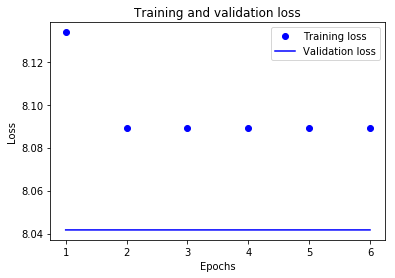

In [61]:
history_dict = history.history
history_dict.keys()

acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

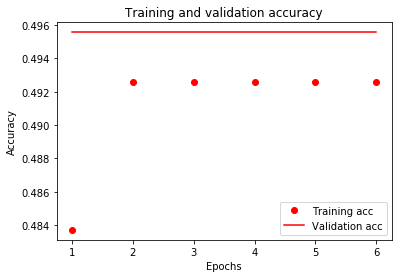

In [62]:
plt.clf()   # clear figure

plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()